In [126]:
import itertools as it
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

### Conjunto de dados

Primeiramente, vamos carregar as bases de dados e separar os rótulos que serão preditos.


In [124]:
# Características
df_sociais = pd.read_csv("data/trabalho5_dados_sociais_4.csv")
df_modulo1 = pd.read_csv("data/trabalho5_dados_modulo1_4.csv")
df_modulo2 = pd.read_csv("data/trabalho5_dados_ateh_modulo2_4.csv")
# Rótulos
y = LabelEncoder().fit(["Não", "Sim"]).transform(df_modulo2["aprovado"])
df_sociais = df_sociais.drop(["id", "aprovado"], axis=1)
df_modulo1 = df_modulo1.drop(["id", "aprovado"], axis=1)
df_modulo2 = df_modulo2.drop(["id", "aprovado"], axis=1)

In [125]:
# Distribuição dos rótulos
data = pd.DataFrame(data=y, columns=["aprovado"]).value_counts().to_frame()
data / data.sum()

,0
aprovado,
0,0.566
1,0.434


A distribuição mostra que um classificador "naive" é capaz de uma acurácia de 57%.

### Pré-processamento

A base de dados sociais é a única que possui variáveis multi-categóricas e ordinais não processadas. Vamos pré-processá-las para que possam ser usadas pelos classificadores.

In [ ]:
# Ordens das categorias
sn_cat = ["Não", "Sim"]
sexo_cat = ["Feminino", "Masculino"]
escolaridade_cat = [
    "Ensino Médio Completo",
    "Ensino Superior Incompleto",
    "Ensino Superior Completo",
    "Pós-graduação",
]
materialdidatico_cat = ["Adequado", "Muito adequado"]
prazoatividades_cat = [
    "Pouquíssimo flexível",
    "Pouco flexível",
    "Flexível",
    "Muito flexível",
]
interacaopares_cat = ["Importante", "Muito importante"]
organizacaocurso_cat = ["Organizado", "Muito organizado"]
import_ajud_tutor_cat = ["Às vezes", "Sempre"]
autoavaliacao_cat = [
    "Não, não considero",
    "Sim, considero, porém, poderia estar me esforçando mais",
    "Sim, considero",
]
pp_cat = [
    "Discordo totalmente",
    "Discordo",
    "Nem discordo, nem concordo",
    "Concordo",
    "Concordo totalmente",
]

In [ ]:
# Variáveis ordinais
cols_ord = [
    "escolaridade",
    "materialdidatico",
    "prazoatividades",
    "interacaopares",
    "import.ajud.tutor",
    "autoavaliacao.x",
] + [f"pp{n + 1:03}" for n in range(37)]
cats_ord = [
    escolaridade_cat,
    materialdidatico_cat,
    prazoatividades_cat,
    interacaopares_cat,
    import_ajud_tutor_cat,
    autoavaliacao_cat,
] + [pp_cat] * 37

# Variáveis nominais
cols_nom = list(set(df_sociais.select_dtypes(object).columns) - set(cols_ord))

# Variáveis numéricas
cols_num = ["idade", "tempodeservico"]

### Estudo das características


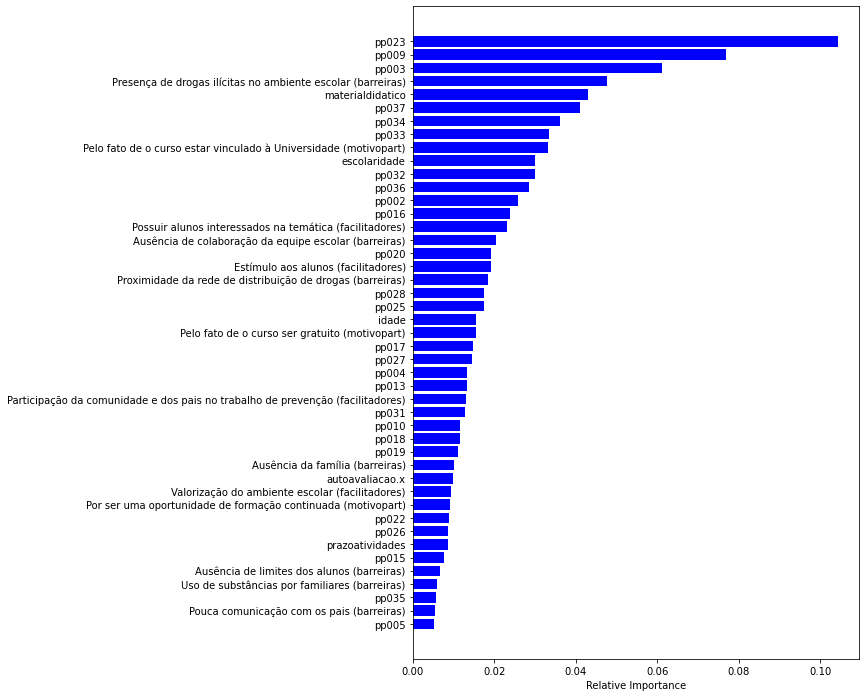

acc = 0.57
f1  = 0.022727272727272728


In [106]:
df_test = pd.concat([df_sociais.drop(cols_nom, axis=1), df_modulo1, df_modulo2], axis=1)
pipe = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    ("ord", OrdinalEncoder(categories=cats_ord), cols_ord),
                    ("num", StandardScaler(), cols_num),
                ]
            ),
        ),
        ("clf", RandomForestClassifier(n_estimators=1000, max_depth=2)),
    ]
)
pipe.fit(X=df_test, y=y)

feature_names = (
    list(set(df_sociais.columns) - set(cols_nom))
    + list(df_modulo1.columns)
    + list(df_modulo2.columns)
)

importances = pipe["clf"].feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 12))
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

y_pred = pipe.predict(X=df_test)
print("acc =", accuracy_score(y, y_pred))
print("f1  =", f1_score(y, y_pred))

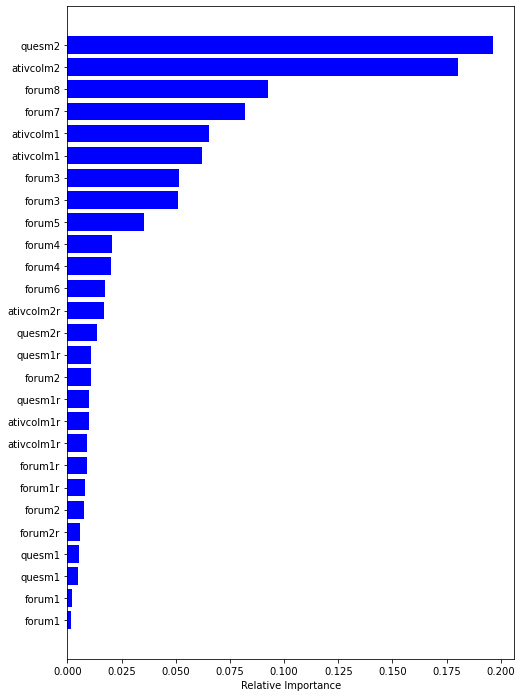

acc = 0.719
f1  = 0.6928961748633881


In [137]:
df_test = pd.concat([df_modulo1, df_modulo2], axis=1)
pipe = Pipeline(
    [
        ("clf", RandomForestClassifier(n_estimators=1000, max_depth=2)),
    ]
)
pipe.fit(X=df_test, y=y)

feature_names = (
    list(df_modulo1.columns)
    + list(df_modulo2.columns)
)

importances = pipe["clf"].feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 12))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

y_pred = pipe.predict(X=df_test)
print("acc =", accuracy_score(y, y_pred))
print("f1  =", f1_score(y, y_pred))

In [127]:
def search_results(X, y, column_combinations, results_path, cache=True):
    try:
        if cache:
            with open(results_path, "rb") as file:
                search_results = pickle.load(file)
        else:
            raise FileNotFoundError()
    except FileNotFoundError:
        search_results = []
        for cols in column_combinations:
            cols_ord_ = list(set(cols_ord) & set(cols))
            cats_ord_ = [cats_ord[cols_ord.index(x)] for x in cols_ord_]
            cols_nom_ = list(set(cols_nom) & set(cols))
            cols_num_ = list(set(cols_num) & set(cols))

            transformers = []
            if cols_ord_:
                transformers.append((OrdinalEncoder(categories=cats_ord_), cols_ord_))
            if cols_nom_:
                transformers.append((OneHotEncoder(), cols_nom_))
            if cols_num_:
                transformers.append((StandardScaler(), cols_num_))

            steps = []
            if transformers:
                steps.append(("transformer", make_column_transformer(*transformers)))
            steps.append(("estimator", LogisticRegression())),  # dummy
            pipe = Pipeline(steps)

            search = GridSearchCV(
                pipe,
                param_grid=[
                    {
                        "estimator": [LogisticRegression()],
                    },
                    {
                        "estimator": [GradientBoostingClassifier()],
                    },
                    {
                        "estimator": [SVC()],
                    },
                ],
                n_jobs=-1,
                scoring="f1_micro",
            )
            _ = search.fit(X[cols], y)

            result = pd.DataFrame(search.cv_results_)
            result["columns"] = [cols] * len(result)
            search_results.append(result)

        search_results = pd.concat(search_results).sort_values(
            by="mean_test_score", ascending=False
        )
        with open(results_path, "wb") as file:
            pickle.dump(search_results, file)

    return search_results

### Dados Sociais


In [128]:
column_combinations = [
    list(cols)
    for n_cols in range(1, len(df_sociais.columns) + 1)
    for cols in it.islice(it.combinations(df_sociais.columns, n_cols), 2)
]
results_sociais = search_results(
    X=df_sociais,
    y=y,
    column_combinations=column_combinations,
    results_path="data/search_results_1.pkl",
    cache=False,
)
results_sociais.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,columns
0,0.016204,0.001721,0.005001,1.168008e-07,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.575,0.570,0.57,0.569,0.003742,1,"[idade, sexo, escolaridade, estadocivil, tempo..."
2,0.036408,0.003879,0.019404,1.020207e-03,SVC(),{'estimator': SVC()},0.565,0.575,0.575,0.555,0.57,0.568,0.007483,1,"[idade, escolaridade]"
0,0.005601,0.000490,0.002201,4.002572e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,[idade]
0,0.008402,0.000490,0.003601,4.899015e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,2,"[idade, escolaridade]"
0,0.018400,0.001200,0.004801,4.001141e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, escolaridade, ocupacao]"


In [129]:
results_sociais.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,465.000000,4.650000e+02,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,0.100372,5.721635e-03,0.016982,0.002032,0.540602,0.513086,0.525624,0.531968,0.545247,0.531305,0.020188,1.969892
std,0.069576,3.978608e-03,0.010641,0.001996,0.027450,0.049728,0.036681,0.023852,0.021849,0.025517,0.013909,0.803519
min,0.005601,1.784161e-07,0.002000,0.000000,0.470000,0.410000,0.460000,0.465000,0.495000,0.484000,0.002000,1.000000
25%,0.053012,2.577436e-03,0.008202,0.000801,0.520000,0.460000,0.500000,0.515000,0.525000,0.508000,0.003742,1.000000
50%,0.069815,4.561542e-03,0.012602,0.001497,0.545000,0.515000,0.525000,0.535000,0.540000,0.518000,0.021354,2.000000
75%,0.149634,7.916409e-03,0.027406,0.002415,0.565000,0.565000,0.560000,0.560000,0.570000,0.564000,0.030496,3.000000
max,0.247076,2.457040e-02,0.045213,0.018152,0.600000,0.580000,0.575000,0.570000,0.575000,0.569000,0.055009,3.000000


### Dados dos módulos


In [130]:
df_modulo = pd.concat([df_modulo1, df_modulo2], axis=1)

column_combinations = [
    list(cols)
    for n_cols in range(1, len(df_modulo.columns) + 1)
    for cols in it.islice(it.combinations(df_modulo.columns, n_cols), 2)
]
results_modulos = search_results(
    X=df_modulo,
    y=y,
    column_combinations=column_combinations,
    results_path="data/search_results_2.pkl",
    cache=False,
)
results_modulos.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,columns
2,0.030407,0.000800,0.016604,0.001357,SVC(),{'estimator': SVC()},0.665,0.760,0.710,0.745,0.705,0.717,0.033257,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
2,0.024405,0.002801,0.035001,0.042005,SVC(),{'estimator': SVC()},0.670,0.750,0.715,0.750,0.700,0.717,0.030594,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
2,0.027406,0.001625,0.015003,0.001674,SVC(),{'estimator': SVC()},0.665,0.760,0.700,0.755,0.695,0.715,0.036742,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
2,0.027206,0.001600,0.015803,0.000749,SVC(),{'estimator': SVC()},0.660,0.765,0.710,0.730,0.705,0.714,0.034264,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
2,0.030007,0.002098,0.017003,0.001096,SVC(),{'estimator': SVC()},0.665,0.750,0.700,0.750,0.705,0.714,0.032465,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."


In [131]:
results_modulos.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,159.000000,1.590000e+02,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,0.040354,1.815039e-03,0.007164,0.001603,0.639843,0.696887,0.683868,0.696572,0.672296,0.677893,0.026910,1.905660
std,0.035695,1.630124e-03,0.008067,0.006542,0.041462,0.059213,0.048607,0.049168,0.043388,0.044962,0.008659,0.832812
min,0.003401,9.536743e-08,0.001399,0.000000,0.520000,0.575000,0.565000,0.585000,0.550000,0.573000,0.004000,1.000000
25%,0.008602,7.484557e-04,0.001912,0.000399,0.632500,0.645000,0.662500,0.670000,0.652500,0.658000,0.022360,1.000000
50%,0.027006,1.166286e-03,0.002001,0.000401,0.655000,0.725000,0.690000,0.705000,0.690000,0.703000,0.029732,2.000000
75%,0.074017,2.480954e-03,0.015203,0.000776,0.665000,0.750000,0.727500,0.740000,0.700000,0.709000,0.031843,3.000000
max,0.122028,8.135599e-03,0.038213,0.043496,0.680000,0.765000,0.765000,0.755000,0.720000,0.717000,0.041521,3.000000


### Todos os dados


In [132]:
df_all = pd.concat([df_sociais, df_modulo1, df_modulo2], axis=1)

column_combinations = [
    list(cols)
    for n_cols in range(1, len(df_all.columns) + 1)
    for cols in it.islice(it.combinations(df_all.columns, n_cols), 2)
]
results_all = search_results(
    X=df_all,
    y=y,
    column_combinations=column_combinations,
    results_path="data/search_results_3.pkl",
    cache=False,
)
results_all.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,columns
0,0.015804,1.600361e-03,0.004801,4.001141e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.575,0.570,0.57,0.569,0.003742,1,"[idade, sexo, escolaridade, estadocivil, tempo..."
2,0.036208,3.059997e-03,0.021005,1.095279e-03,SVC(),{'estimator': SVC()},0.565,0.575,0.575,0.555,0.57,0.568,0.007483,1,"[idade, escolaridade]"
0,0.005001,2.336015e-07,0.003001,1.168008e-07,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,[idade]
0,0.018204,1.600134e-03,0.005001,1.784161e-07,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, escolaridade, ocupacao]"
0,0.009002,3.504023e-07,0.003201,4.000187e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo]"


In [133]:
results_all.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,627.000000,6.270000e+02,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.104168,4.967298e-03,0.017183,0.001857,0.540718,0.511396,0.521635,0.534250,0.544681,0.530536,0.020271,1.972887
std,0.070728,3.105240e-03,0.010247,0.001367,0.025507,0.048750,0.038343,0.022185,0.021383,0.025491,0.013448,0.803883
min,0.005001,9.536743e-08,0.002000,0.000000,0.470000,0.410000,0.460000,0.470000,0.485000,0.477000,0.002000,1.000000
25%,0.056613,2.638881e-03,0.008602,0.000800,0.520000,0.460000,0.492500,0.520000,0.525000,0.508000,0.003742,1.000000
50%,0.075417,4.224748e-03,0.015403,0.001470,0.545000,0.500000,0.515000,0.535000,0.535000,0.516000,0.025179,2.000000
75%,0.163136,6.512855e-03,0.027506,0.002450,0.565000,0.565000,0.560000,0.560000,0.570000,0.564000,0.030331,3.000000
max,0.243456,1.751505e-02,0.037008,0.007421,0.600000,0.580000,0.575000,0.570000,0.575000,0.569000,0.054681,3.000000
